In [1]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL = ''
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
ALGORITHM_DETAIL += ' tbc'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [2]:
! pip install scikeras
! pip install catboost

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)

def make_simple_ann(key):

    key = 'simplest'

    if key == 'simplest':
        ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'simplest findable model + normalise, MSE loss'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        even_simpler_model = tf.keras.Sequential([
            normalizer,
            layers.Dense(units=1)
        ])

        even_simpler_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
            loss='mean_squared_error')

        trainable_model = even_simpler_model

    elif key == 'quite simple':
        ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'simplest findable model + normalise, mae'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        even_simpler_model = tf.keras.Sequential([
            normalizer,
            layers.Dense(units=1)
        ])

        even_simpler_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
            loss='mean_absolute_error')

        trainable_model = even_simpler_model

    elif key == 'my model':
        ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG  + 'my model (make_regression_ann)'

        simple_model = make_regression_ann()
        trainable_model = simple_model
    else:
        raise ValueError("make_simple_ann: no entry for key:", key)

    return trainable_model, ALGORITHM_DETAIL

def make_regression_ann(key, initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    model = Sequential()
    #model.add(normalizer)
    model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    #print(model)

    description = '[input11, d^20-500-500-20-5, dense1]'
    return model, description


2022-11-20 01:29:47.891707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [4]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)

no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
not_catboost = True

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_0__common_20221116 import get_columns
    from functions_b__get_the_data_20221116 import set_csv_directory, get_combined_dataset
    from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
    from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
    from functions_d3__prepare_store_data_20221116 import create_train_test_data
    from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
    from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

    set_csv_directory('final_split')

    quick_mode = True
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_0__common_20221116 import get_columns
    from functions_b__get_the_data_20221116 import set_csv_directory, get_combined_dataset
    from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
    from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
    from functions_d3__prepare_store_data_20221116 import create_train_test_data
    from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
    from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results
    
# if quick_mode:
#     OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10
#
# if 'neural' in ALGORITHM.lower():
#     OVERRIDE_JOBS=1
#
# if 'neural' in ALGORITHM.lower() and not cloud_run:
#     OVERRIDE_N_ITER = 2

if quick_mode:
    OVERRIDE_EPOCHS=5
else:
    OVERRIDE_EPOCHS=None

{'notebook_environment': 'local', 'use_gpu': False, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [5]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [6]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [7]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [8]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [9]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [10]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [12]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [13]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [14]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [15]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [16]:
starter_pipe = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=0), DATA_DETAIL)
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(model=<function make_regression_ann at 0x7fbdedc1bf70>, verbose=0))])

In [17]:
starter_model = starter_pipe[-1]
default_model_params = starter_model.get_params()
default_model_params

{'model': <function __main__.make_regression_ann(key, initializer='uniform', activation='relu', optimizer='adam', loss='mse')>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 0,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1}

In [18]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [19]:
trainable_model, detail = make_simple_ann('simplest')
ALGORITHM_DETAIL = ALGORITHM_DETAIL_ORIG + " " + detail
#make_regression_ann('not used', )

2022-11-20 01:29:58.875133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
#history = starter_pipe[-1].fit(
#history = simple_model.fit(
history = trainable_model.fit(
    X_train,
    y_train,
    epochs=100 if not OVERRIDE_EPOCHS else OVERRIDE_EPOCHS,
    # verbose=0 to suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
)

Epoch 1/5
993/993 [==============================] - 8s 7ms/step - loss: 192113475584.0000 - val_loss: 192972718080.0000
Epoch 2/5
993/993 [==============================] - 6s 6ms/step - loss: 192014974976.0000 - val_loss: 192872448000.0000
Epoch 3/5
993/993 [==============================] - 6s 6ms/step - loss: 191916113920.0000 - val_loss: 192772177920.0000
Epoch 4/5
993/993 [==============================] - 6s 6ms/step - loss: 191817498624.0000 - val_loss: 192672448512.0000
Epoch 5/5
993/993 [==============================] - 6s 6ms/step - loss: 191718981632.0000 - val_loss: 192572751872.0000


In [21]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
0,1.921135e+11,1.929727e+11,0
1,1.920150e+11,1.928724e+11,1
2,1.919161e+11,1.927722e+11,2
3,1.918175e+11,1.926724e+11,3
4,1.917190e+11,1.925728e+11,4


In [22]:
y_pred = trainable_model.predict(X_test)

138/138 [==============================] - 1s 4ms/step


In [23]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy -15.951241450522414
Mean Absolute Error Accuracy 424575.27787991683
Mean Squared Error Accuracy 191488099337.006
Root Mean Squared Error 437593.5321014309


In [24]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [25]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,-101.215027,400101.215027,100.025304,3.952982e+05
119328242,369950.0,-26.258911,369976.258911,100.007098,1.408955e+06
125716790,350000.0,476.475647,349523.524353,99.863864,7.335601e+04
122440040,549000.0,287.284332,548712.715668,99.947671,1.909999e+05
120508103,495000.0,835.020142,494164.979858,99.831309,5.918001e+04
...,...,...,...,...,...
68620869,475000.0,1704.337280,473295.662720,99.641192,2.777007e+04
85735665,575000.0,2629.389648,572370.610352,99.542715,2.176819e+04
125706338,400000.0,-60.589966,400060.589966,100.015147,6.602753e+05


In [26]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted','actual','Price','bedrooms','bathrooms']] = combined[['predicted','actual','Price','bedrooms','bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
96602536,170000,-504,170504.493408,100.296761,33797.169722,170000,1,1,0.321060,51.338530,-0.013780,0.161190,0.090640,LEASEHOLD
109722224,108000,-289,108289.956360,100.268478,37346.984357,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
125083952,180000,-451,180451.075378,100.250597,40004.638695,180000,1,1,0.858985,51.604984,0.238017,0.105264,0.342437,LEASEHOLD
112148798,195000,-474,195474.881226,100.243529,41162.899414,195000,1,1,1.124854,51.608846,0.230014,0.109126,0.334434,LEASEHOLD
79400709,210000,-474,210474.051819,100.225739,44398.954598,210000,1,1,0.166615,51.375842,0.085871,0.123878,0.190291,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118846151,399995,2303,397691.979004,99.424238,17268.274136,399995,4,3,1.128960,51.506300,0.116570,0.006580,0.220990,FREEHOLD
122896754,525000,3025,521974.547852,99.423723,17252.778171,525000,5,4,0.511600,51.551420,0.072500,0.051700,0.176920,FREEHOLD
119768288,400000,2322,397677.094727,99.419274,17119.815400,400000,4,3,0.637887,51.492317,0.135397,0.007403,0.239817,FREEHOLD
122834111,499995,3331,496663.148926,99.333623,14906.523067,499995,6,4,0.514528,51.482780,0.089120,0.016940,0.193540,FREEHOLD


In [27]:
r2score = r2_score(y_test, y_pred)
r2score

-15.951241450522414

138/138 [==============================] - 1s 4ms/step


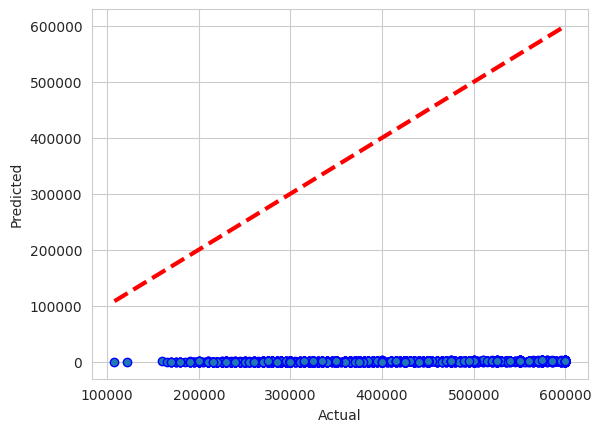

In [28]:
fig, ax = plt.subplots()
#ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.scatter(y_test, trainable_model.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [29]:
#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"] if not_catboost else 999
cv_best_model_fit_time = 999


DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method =  f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    #'_score': score,
    '_score': r2score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    #'_params': crossval_runner.best_params_ if not_catboost else cat_params,
    '_params': 'not available',
    '_method':method,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)

neural network (v06)


In [30]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
#        if not_catboost:
#            pickle.dump(crossval_runner.best_estimator_, f)
#        else:
#            pickle.dump(starter_model, f)
        pickle.dump(trainable_model, f)
        print('pickled new version of model')
        print(f"{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})")
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    print("not updated saved model, the previous run was better")
    print(old_results_json[key]['_score'], 'is worse than or equal to', old_best_score)


not updated saved model, the previous run was better
-15.951241450522414 is worse than or equal to 0.5566961181655233
